<a href="https://colab.research.google.com/github/optichkina/project/blob/main/RealEstatePricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import random
import math
from scipy import stats

import sklearn as skl
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams


Задача: 
предсказать цены на квартиры

In [3]:
train=pd.read_csv('train.csv')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [4]:
train.info() #информация о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [5]:
train   #обзор

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


In [6]:
train.describe(include='all')   #обобщенные статистики по датасету

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000,10000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9903,9725,NaN,NaN,NaN,NaN,NaN,NaN,9175,NaN
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,NaN,NaN,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,NaN,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,NaN,NaN,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,NaN,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,NaN,NaN,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,NaN,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,NaN,NaN,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,NaN,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,NaN,NaN,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,NaN,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,NaN,NaN,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,NaN,249135.462171


### Анализ данных

In [7]:
#id переводим в формат str, для исключения влияния на обучение модели
train['Id'] = train['Id'].astype(str)

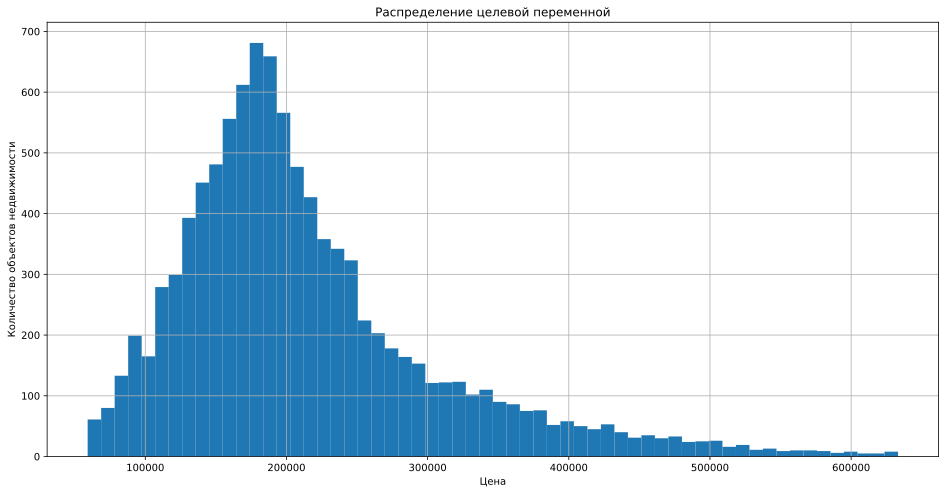

In [8]:
#оценка целевой переменной (цена) с помощью построения гистограммы
plt.figure(figsize = (16,8))
train['Price'].hist(bins= 60)
plt.xlabel('Цена')
plt.ylabel('Количество объектов недвижимости')
plt.title('Распределение целевой переменной')
plt.show()

In [9]:
#медиана и среднее цены
price=train['Price']
price_sort = sorted(price)
median = np.quantile(price_sort, q=0.5).round(3)
mean = np.mean(price_sort).round(3)
print(median)
print(mean)

192269.645
214138.857


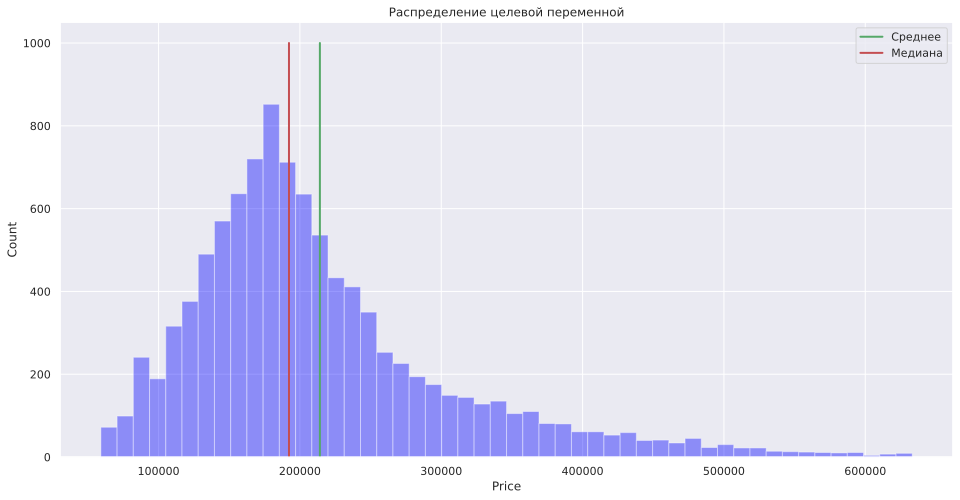

In [10]:
plt.figure(figsize = (16, 8))

sns.set(font_scale=1)
sns.distplot(price_sort, color='blue', bins=50, kde=False)

y = np.linspace(0, 1000, 10)
plt.plot([mean] * 10, y, label='Среднее',  linewidth=2, color='g')
plt.plot([median] * 10, y, label='Медиана',  linewidth=2, color='r')

plt.title('Распределение целевой переменной')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b047e0650>,
      dtype=object)

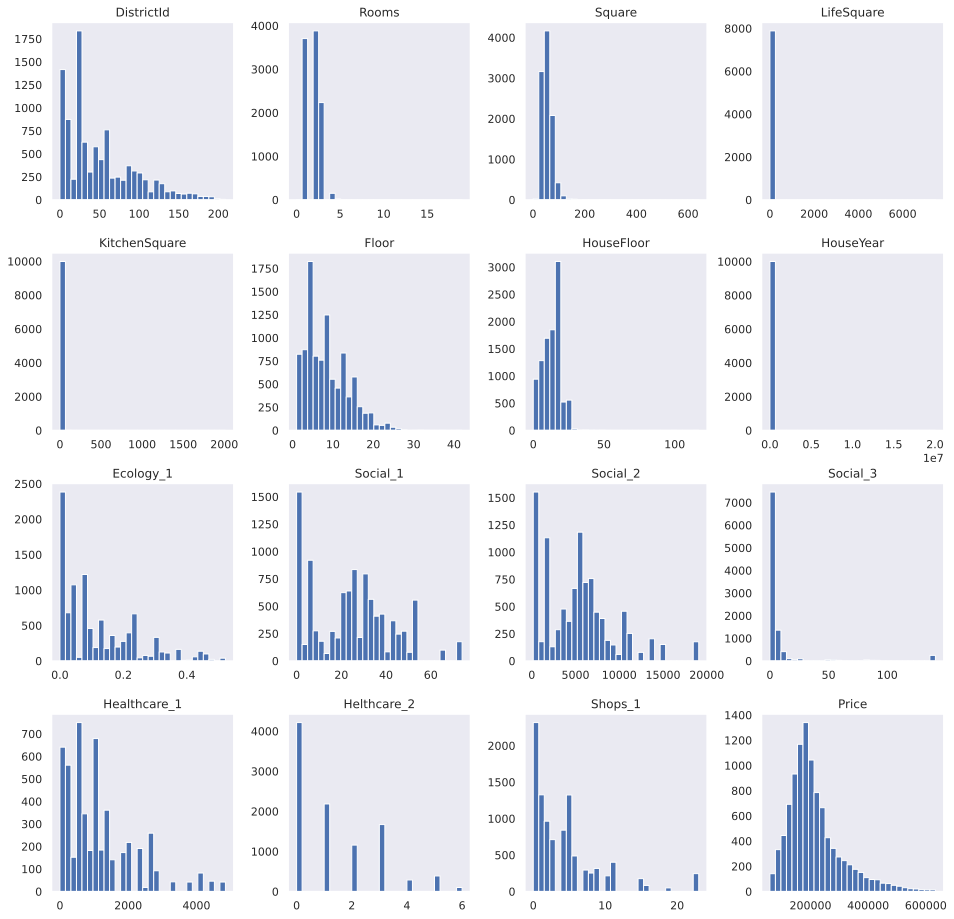

In [11]:
train.hist(figsize= (16,16), bins = 30, grid=False)

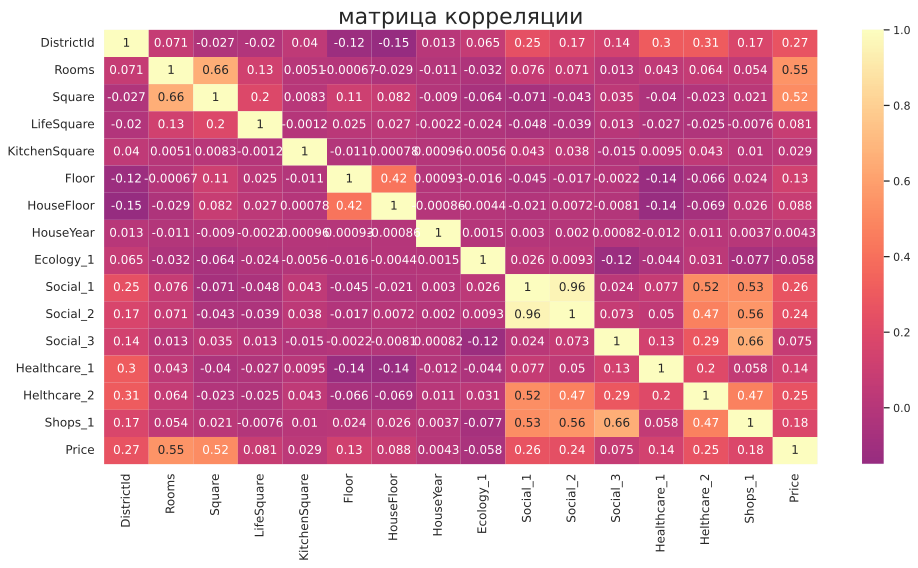

In [12]:
plt.figure(figsize=(16,8), dpi= 80)               #построение матрицы корреляции
sns.heatmap(train.corr(), xticklabels=train.corr().columns, yticklabels=train.corr().columns, cmap='magma', center=0, annot=True)

# Decorations
plt.title('матрица корреляции', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [13]:
train.isna().sum()        #поиск незаполненых значений. большое количество незаполненых значений в LifeSquare и Healthcare_1. т.к. у нас всего 10000 наблюдений количество пропусков в обоих случаях значительное.

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [14]:
train['Square'].value_counts()

26.553188     1
46.363496     1
100.751999    1
70.726600     1
40.523022     1
             ..
76.481158     1
86.915187     1
82.482521     1
43.112986     1
97.664912     1
Name: Square, Length: 10000, dtype: int64

In [15]:
#заполняем неизвестные значения жилой площади используя среднюю общую площадь и среднюю площадь кухни (разница между ними будет являться жилой площадью)
train['Square'].mean()

56.315775197935615

In [16]:
train['KitchenSquare'].mean()

6.2733

In [17]:
new_ls= train['Square'].mean() - train['KitchenSquare'].mean()
print(new_ls)

50.042475197935616


In [18]:
train.loc[train['LifeSquare'].isna(), 'LifeSquare'] = new_ls  #заменили недостающие значения жилой площади разницой между общей площадью и площадью кухни
                               

In [19]:
train['LifeSquare'].value_counts()

50.042475    2113
28.003539       1
49.942477       1
25.688943       1
44.662105       1
             ... 
40.734262       1
37.980219       1
17.130385       1
33.273700       1
28.421652       1
Name: LifeSquare, Length: 7888, dtype: int64

In [20]:
median= train['Healthcare_1'].median()    #заменили недостающие значения в Healthcare_1 медианой
train['Healthcare_1'].fillna(median, inplace=True)

In [21]:
train['Healthcare_1'].value_counts()

900.0     4869
540.0      511
30.0       348
1046.0     245
750.0      163
          ... 
370.0       14
32.0        12
1815.0      10
35.0         2
0.0          1
Name: Healthcare_1, Length: 79, dtype: int64

In [22]:
train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,39.913335,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,76.767998,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,38.334514,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,50.042475,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [23]:
train['HouseFloor_outlier'] = 0
train.loc[(train['HouseFloor'] < 1) | (train['HouseFloor'] > 90) | (train['Floor'] > train['HouseFloor']), 'HouseFloor_outlier'] = 1
train.loc[(train['HouseFloor_outlier'] == 1) & (train['HouseFloor'] < 1), 'HouseFloor'] = train['Floor']
train.loc[(train['HouseFloor_outlier'] == 1) & (train['HouseFloor'] > 90) & (train['Floor'] <= 17), 'HouseFloor'] = 17
train.loc[(train['HouseFloor_outlier'] == 1) & (train['HouseFloor'] > 90) & (train['Floor'] > 17), 'HouseFloor'] = train['Floor']
train.loc[train['Floor'] > train['HouseFloor'], 'HouseFloor'] = train['Floor']


In [24]:
current_year = datetime.now().year
train['HouseYear_outlier'] = 0
train.loc[train['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
train.loc[train['HouseYear'] <= 1900, 'HouseYear_outlier'] = 1
train.loc[train['HouseYear'] == 20052011, 'HouseYear'] == 2011
train.loc[train['HouseYear'] > current_year, 'HouseYear'] = current_year
train.loc[train['HouseYear'] <= 1900, 'HouseYear_outlier'] = 1900

In [25]:
train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,HouseFloor_outlier,HouseYear_outlier
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,39.913335,6.273300,8.526700,13.409300,1984.872800,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.182800,0.000200
std,43.587592,0.839512,21.058732,76.767998,28.560917,5.241148,5.882434,18.417132,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.386522,0.014141
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000
25%,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,0.000000,0.000000
50%,36.000000,2.000000,52.513310,38.334514,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,0.000000
75%,75.000000,2.000000,65.900625,50.042475,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,0.000000,0.000000
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,48.000000,2022.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000


In [63]:
def evaluate_preds (train_true_values, train_pred_values, test_true_values, test_pred_values):
  """Оценка качества модели и график"""
  print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values),3)))
  print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values),3)))

  

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  object 
 1   DistrictId          10000 non-null  int64  
 2   Rooms               10000 non-null  float64
 3   Square              10000 non-null  float64
 4   LifeSquare          10000 non-null  float64
 5   KitchenSquare       10000 non-null  float64
 6   Floor               10000 non-null  int64  
 7   HouseFloor          10000 non-null  float64
 8   HouseYear           10000 non-null  int64  
 9   Ecology_1           10000 non-null  float64
 10  Ecology_2           10000 non-null  object 
 11  Ecology_3           10000 non-null  object 
 12  Social_1            10000 non-null  int64  
 13  Social_2            10000 non-null  int64  
 14  Social_3            10000 non-null  int64  
 15  Healthcare_1        10000 non-null  float64
 16  Helth

In [28]:
# замена параметров Ecology_2, Ecology_3, Shops_2' с типом object на dummie-переменные с числовым значением
train = pd.concat([train, pd.get_dummies(train['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
train = pd.concat([train, pd.get_dummies(train['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
train = pd.concat([train, pd.get_dummies(train['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)

In [31]:
train.info() #итоговый вид датасета

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  object 
 1   DistrictId          10000 non-null  int64  
 2   Rooms               10000 non-null  float64
 3   Square              10000 non-null  float64
 4   LifeSquare          10000 non-null  float64
 5   KitchenSquare       10000 non-null  float64
 6   Floor               10000 non-null  int64  
 7   HouseFloor          10000 non-null  float64
 8   HouseYear           10000 non-null  int64  
 9   Ecology_1           10000 non-null  float64
 10  Ecology_2           10000 non-null  object 
 11  Ecology_3           10000 non-null  object 
 12  Social_1            10000 non-null  int64  
 13  Social_2            10000 non-null  int64  
 14  Social_3            10000 non-null  int64  
 15  Healthcare_1        10000 non-null  float64
 16  Helth

Отбор признаков и построение модели

In [45]:
X = pd.DataFrame(train, columns=('Id','DistrictId','Rooms','Square','LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_A','Ecology_2_B', 'Ecology_3_A','Ecology_3_B', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2_A','Shops_2_B'))

target= ['Price']
y=train[target]

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [54]:
rf_model = RandomForestRegressor( random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

In [64]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Train R2:	0.959
Test R2:	0.735


In [ ]:
Кросс-валидация

In [66]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72380941, 0.66427946, 0.71338409])

In [67]:
cv_score.mean()

0.7004909867761415

In [68]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.378990
14,Social_1,0.098427
15,Social_2,0.096933
2,Rooms,0.078607
16,Social_3,0.050281
1,DistrictId,0.048475
9,Ecology_1,0.035035
8,HouseYear,0.033179
4,LifeSquare,0.029973
7,HouseFloor,0.027391


Прогнозирование на тестовом датасете

подготовка тестового датасета

In [75]:
test=pd.read_csv('test.csv')

In [78]:
test.shape

(5000, 19)

In [86]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   5000 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [83]:
median= (train['Healthcare_1']).median()    #заменили недостающие значения в Healthcare_1 медианой
test['Healthcare_1'].fillna(median, inplace=True)

In [85]:
test['LifeSquare'].fillna(new_ls, inplace=True)

In [87]:
test['LifeSquare'].value_counts()

50.042475    1041
41.117117       1
52.121309       1
21.149389       1
24.056712       1
             ... 
45.553089       1
44.301666       1
21.209560       1
85.531172       1
23.833149       1
Name: LifeSquare, Length: 3960, dtype: int64

In [89]:
test['HouseFloor_outlier'] = 0
test.loc[(test['HouseFloor'] < 1) | (test['HouseFloor'] > 90) | (test['Floor'] > test['HouseFloor']), 'HouseFloor_outlier'] = 1
test.loc[(test['HouseFloor_outlier'] == 1) & (test['HouseFloor'] < 1), 'HouseFloor'] = test['Floor']
test.loc[(test['HouseFloor_outlier'] == 1) & (test['HouseFloor'] > 90) & (test['Floor'] <= 17), 'HouseFloor'] = 17
test.loc[(test['HouseFloor_outlier'] == 1) & (test['HouseFloor'] > 90) & (test['Floor'] > 17), 'HouseFloor'] = test['Floor']
test.loc[test['Floor'] > test['HouseFloor'], 'HouseFloor'] = test['Floor']

In [90]:
current_year = datetime.now().year
test['HouseYear_outlier'] = 0
test.loc[test['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
test.loc[test['HouseYear'] <= 1900, 'HouseYear_outlier'] = 1
test.loc[test['HouseYear'] == 20052011, 'HouseYear'] == 2011
test.loc[test['HouseYear'] > current_year, 'HouseYear'] = current_year
test.loc[test['HouseYear'] <= 1900, 'HouseYear_outlier'] = 1900

In [91]:
test = pd.concat([test, pd.get_dummies(test['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
test = pd.concat([test, pd.get_dummies(test['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
test = pd.concat([test, pd.get_dummies(test['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)

In [92]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,HouseFloor_outlier,HouseYear_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000,5000.0,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,39.049389,5.976800,8.632000,13.378800,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.15080,0.0,0.009600,0.990400,0.029800,0.970200,0.082400,0.917600
std,4832.674037,44.179466,0.838594,19.092787,16.833203,9.950018,5.483228,6.113525,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.35789,0.0,0.097518,0.097518,0.170052,0.170052,0.275001,0.275001
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,25.850152,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,0.00000,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,38.310637,6.000000,7.000000,14.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,0.00000,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12598.250000,77.000000,2.000000,66.285129,50.042475,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,0.00000,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,78.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.00000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [103]:
test=pd.DataFrame(test, columns=('Id','DistrictId','Rooms','Square','LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_A','Ecology_2_B', 'Ecology_3_A','Ecology_3_B', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2_A','Shops_2_B'))

In [94]:
submit=pd.read_csv('sample_submission.csv')

In [95]:
submit

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0
...,...,...
4995,10379,200000.0
4996,16138,200000.0
4997,3912,200000.0
4998,5722,200000.0


In [104]:
predictions=rf_model.predict(test)
predictions

array([163045.46411509, 114105.12817937, 140150.22745762, ...,
       146717.0322862 , 186978.67948529, 280632.91828814])

In [105]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,163045.464115
1,5925,114105.128179
2,960,140150.227458
3,3848,121924.670832
4,746,198463.504117


In [106]:
submit.to_csv('rf_submit.csv', index=False)